C:\Users\rbk\AppData\Local\Temp\ipykernel_19040\1139232628.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=4, fontsize=15, frameon=False)


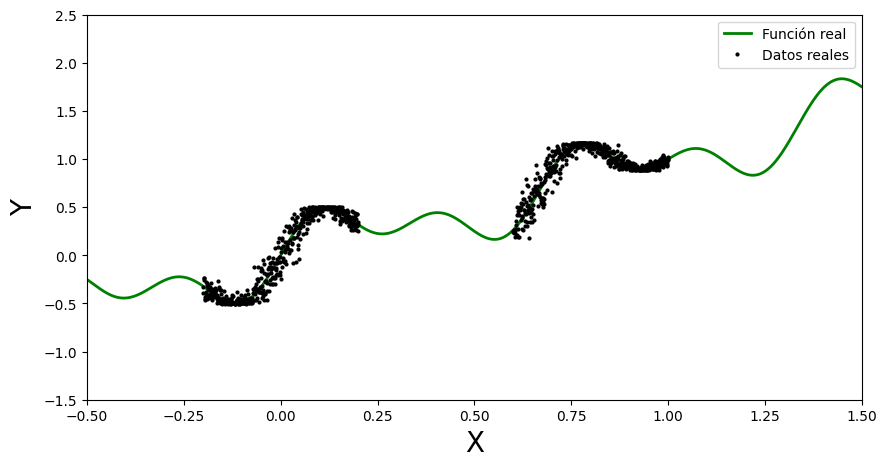

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(8)

# Generate 
def generate_data():
    x = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
    noise = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.25 * np.sin(3 * np.pi * (x + noise)) + 0.2 * np.sin(6 * np.pi * (x + noise)) + noise
    return x, y

x_obs, y_obs = generate_data()

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.25 * np.sin(3 * np.pi * x_true) + 0.2 * np.sin(6 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=20)
ax.set_ylabel("Y", fontsize=20)
ax.legend(loc=4, fontsize=15, frameon=False)
ax.plot(x_true, y_true, 'g-', linewidth=2, label="Función real")
ax.plot(x_obs, y_obs, 'ko', markersize=2, label="Observaciones")
ax.legend()

plt.show()

In [2]:
# Modelo de red neuronal estándar
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 30)
        self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(15, 10)
        self.fc4 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

# Preparación de datos
x_train = torch.from_numpy(x_obs).float().reshape(-1, 1)
y_train = torch.from_numpy(y_obs).float().reshape(-1, 1)

In [3]:
# Entrenamiento
model = NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000
losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.5375
Epoch 500, Loss: 0.0372
Epoch 1000, Loss: 0.0329
Epoch 1500, Loss: 0.0174
Epoch 2000, Loss: 0.0073
Epoch 2500, Loss: 0.0068
Epoch 3000, Loss: 0.0065
Epoch 3500, Loss: 0.0063
Epoch 4000, Loss: 0.0062
Epoch 4500, Loss: 0.0061


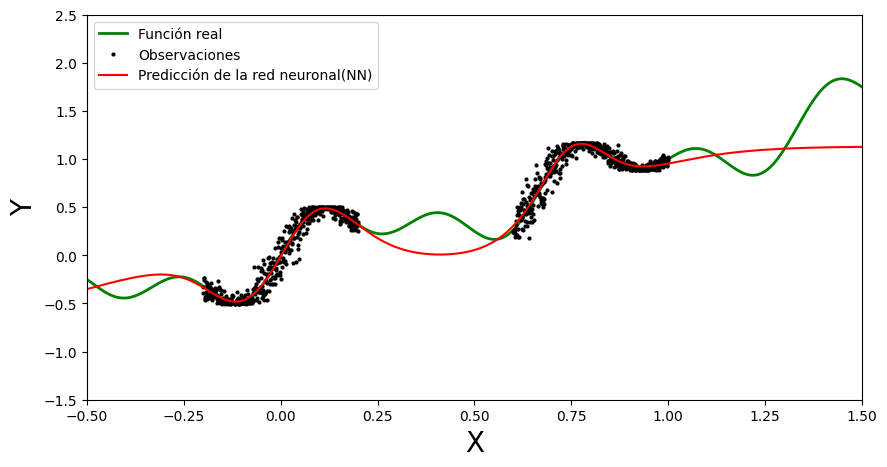

In [4]:
# Predicción
model.eval()
x_test = torch.linspace(-0.5, 1.5, 1000).reshape(-1, 1)
y_test_pred = model(x_test).detach().numpy()

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=20)
ax.set_ylabel("Y", fontsize=20)
ax.plot(x_true, y_true, 'g-', linewidth=2, label="Función real")
ax.plot(x_obs, y_obs, 'ko', markersize=2, label="Observaciones")
ax.plot(x_test, y_test_pred, label="Predicción de la red neuronal(NN)", color="red")
ax.legend()
plt.show()

In [14]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class BayesianNN(PyroModule):
    def __init__(self):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, 30)
        self.fc1.weight = PyroSample(dist.Normal(0., 5.).expand([30, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 5.).expand([30]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](30, 15)
        self.fc2.weight = PyroSample(dist.Normal(0., 5.).expand([15, 30]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 5.).expand([15]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](15, 10)
        self.fc3.weight = PyroSample(dist.Normal(0., 5.).expand([10, 15]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 5.).expand([10]).to_event(1))

        self.fc4 = PyroModule[nn.Linear](10, 1)
        self.fc4.weight = PyroSample(dist.Normal(0., 5.).expand([1, 10]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 5.).expand([1]).to_event(1))

        self.tanh = nn.Tanh()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        mu = self.fc4(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [15]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

model = BayesianNN()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(5000)
b_x_train = torch.from_numpy(x_obs).float()
b_y_train = torch.from_numpy(y_obs).float()
for epoch in bar:
    loss = svi.step(b_x_train, b_y_train)
    bar.set_postfix(loss=f'{loss / x_obs.shape[0]:.3f}')

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:14<00:00, 67.14it/s, loss=1.995] 


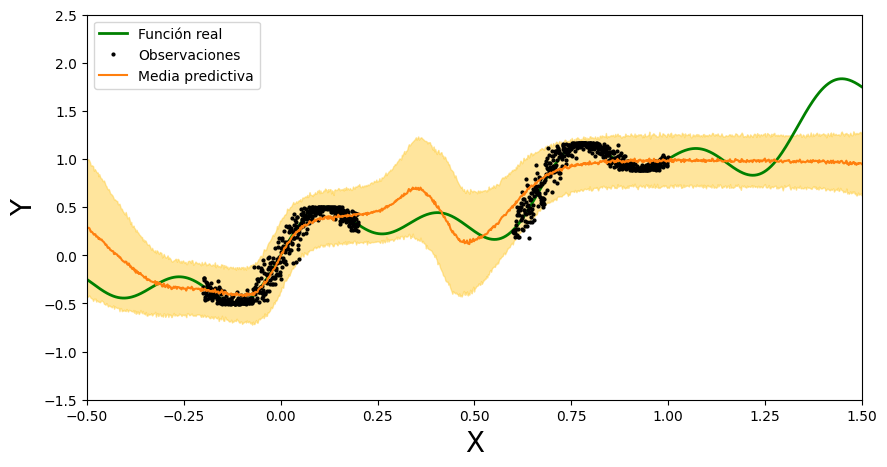

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=500)
x_test = torch.linspace(-0.5, 1.5, 1000)
preds = predictive(x_test)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)


# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=20)
ax.set_ylabel("Y", fontsize=20)
ax.plot(x_true, y_true, 'g-', linewidth=2, label="Función real")
ax.plot(x_obs, y_obs, 'ko', markersize=2, label="Observaciones")
ax.plot(x_test, y_pred,color='#ff7f0e', label="Media predictiva")
ax.fill_between(x_test, y_pred - y_std, y_pred +  y_std,
                alpha=0.5, color='#ffcd3c')
ax.legend()
plt.show()

In [8]:
from pyro.infer import MCMC, NUTS

model = BayesianNN()

# Set Pyro random seed
pyro.set_rng_seed(8)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Warmup:   0%|          | 0/100 [00:00, ?it/s]C:\Users\rbk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyro\poutine\subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 100/100 [10:01,  6.02s/it, step size=1.07e-03, acc. prob=0.768]


In [9]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(-0.5, 1.5, 1000)
preds = predictive(x_test)

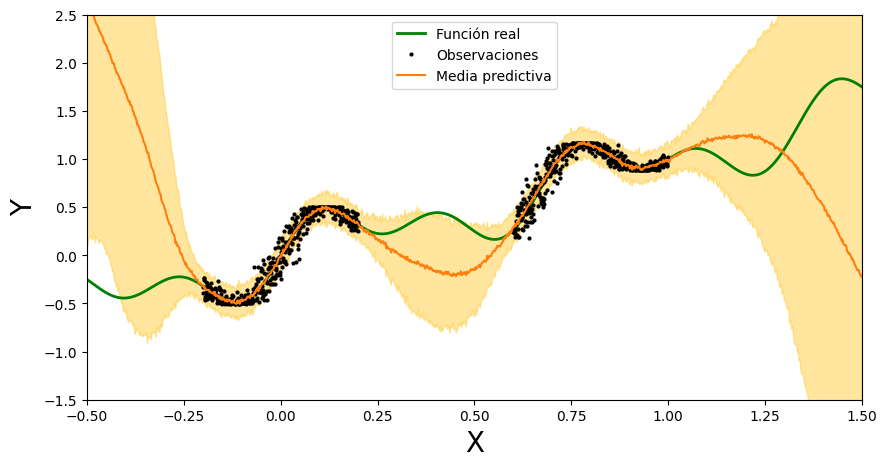

In [10]:
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)


# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=20)
ax.set_ylabel("Y", fontsize=20)
ax.plot(x_true, y_true, 'g-', linewidth=2, label="Función real")
ax.plot(x_obs, y_obs, 'ko', markersize=2, label="Observaciones")
ax.plot(x_test, y_pred,color='#ff7f0e', label="Media predictiva")
ax.fill_between(x_test, y_pred - 2* y_std, y_pred +  2*y_std,
                alpha=0.5, color='#ffcd3c')
ax.legend()
plt.show()

In [11]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class BayesianNN2(PyroModule):
    def __init__(self):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](1, 30)
        self.fc1.weight = PyroSample(dist.Normal(0., 4.).expand([30, 1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 4.).expand([30]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](30, 15)
        self.fc2.weight = PyroSample(dist.Normal(0., 4.).expand([15, 30]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 4.).expand([15]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](15, 10)
        self.fc3.weight = PyroSample(dist.Normal(0., 4.).expand([10, 15]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 4.).expand([10]).to_event(1))

        self.fc4 = PyroModule[nn.Linear](10, 1)
        self.fc4.weight = PyroSample(dist.Normal(0., 4.).expand([1, 10]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 4.).expand([1]).to_event(1))

        self.tanh = nn.Tanh()

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        mu = self.fc4(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [12]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

model = BayesianNN2()
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(15000)
b_x_train = torch.from_numpy(x_obs).float()
b_y_train = torch.from_numpy(y_obs).float()
for epoch in bar:
    loss = svi.step(b_x_train, b_y_train)
    bar.set_postfix(loss=f'{loss / x_obs.shape[0]:.3f}')

100%|██████████| 15000/15000 [06:15<00:00, 39.93it/s, loss=0.437] 


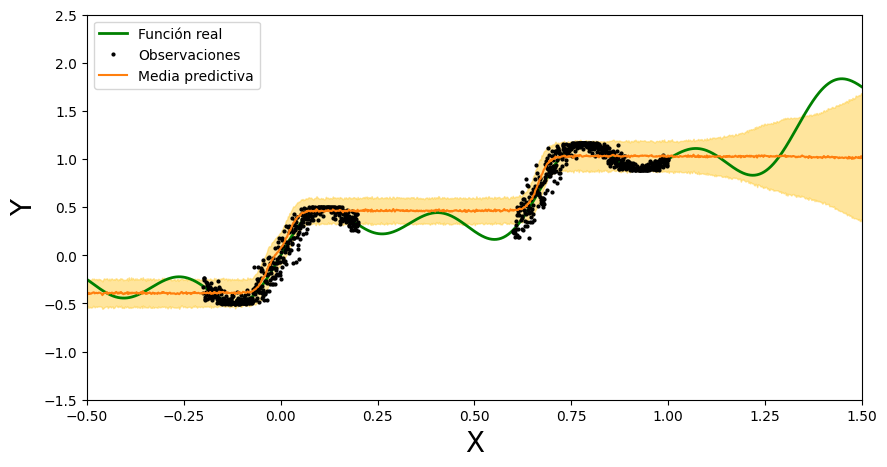

In [13]:
predictive = Predictive(model, guide=guide, num_samples=500)
x_test = torch.linspace(-0.5, 1.5, 1000)
preds = predictive(x_test)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)


# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=20)
ax.set_ylabel("Y", fontsize=20)
ax.plot(x_true, y_true, 'g-', linewidth=2, label="Función real")
ax.plot(x_obs, y_obs, 'ko', markersize=2, label="Observaciones")
ax.plot(x_test, y_pred,color='#ff7f0e', label="Media predictiva")
ax.fill_between(x_test, y_pred - y_std, y_pred +  y_std,
                alpha=0.5, color='#ffcd3c')
ax.legend()
plt.show()